In [1]:
using StateSpaceDynamics, Plots


In [2]:
model = initialize_slds()

SwitchingLinearDynamicalSystem([0.96 0.04; 0.04 0.96], StateSpaceDynamics.LinearDynamicalSystem[StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([0.9452539570141245 -0.09484174581448675; 0.09484174581448675 0.9452539570141245], [0.001 0.0; 0.0 0.001], [0.0, 0.0], [0.001 0.0; 0.0 0.001]), StateSpaceDynamics.GaussianObservationModel{Float64}([-0.31498797116895605 0.4338858743048611; -0.31125240132442067 -0.3954398407537453; … ; -0.8253345499750688 -0.9654904870197227; 0.840288523245819 0.9656607495563969], [0.001 0.0 … 0.0 0.0; 0.0 0.001 … 0.0 0.0; … ; 0.0 0.0 … 0.001 0.0; 0.0 0.0 … 0.0 0.001]), 2, 10, Bool[1, 1, 1, 1, 1, 1]), StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([-0.39533949471978524 -0.86383255548

In [3]:
T = 1000
# Generate synthetic data
x, y, z = sample(model, T)


([0.012781148406102944 -0.043551433682513074 … 0.00918994518478555 0.032159415587346474; 0.03788281101630884 -0.021698572664429976 … -0.08498702535863967 -0.10696223889695364], [-0.0037362031674817928 0.011184638740456908 … -0.07094318488635357 -0.050323491624458885; 0.01979088919057409 0.030620168627788776 … 0.030785185388674228 0.0675583423786563; … ; -0.06176123606409473 0.086548578688241 … 0.137359927485125 0.03213684839745746; 0.042094688716242876 -0.10110240825174423 … -0.06636174473552493 -0.08508079724902803], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

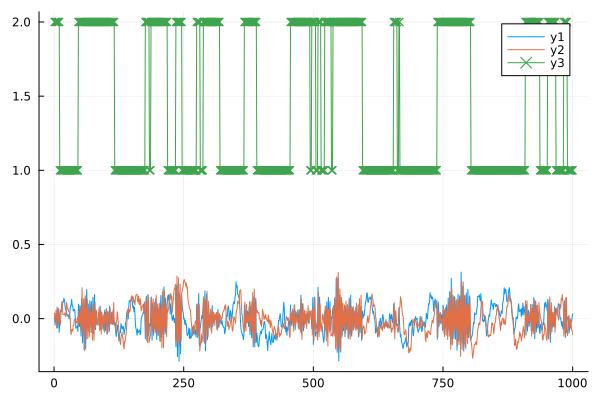

In [4]:
plot(x')
plot!(z, marker=:x)

In [15]:
using LinearAlgebra

p = model.B[1].obs_dim
d = model.B[1].latent_dim

K = model.K
A = [0.9 0.1; 0.2 0.8]
A ./= sum(A, dims=2) # Normalize rows to sum to 1

πₖ = rand(K)
πₖ ./= sum(πₖ) # Normalize to sum to 1

Q = Matrix(0.5 * I(d))

x0 = [0.0; 0.0]
P0 = Matrix(0.5 * I(d))

# set up the observation parameters
C = randn(p, d)
R = Matrix(0.001 * I(p))

B = [StateSpaceDynamics.LinearDynamicalSystem(
    StateSpaceDynamics.GaussianStateModel(0.95 * [cos(f) -sin(f); sin(f) cos(f)], Q, x0, P0),
    StateSpaceDynamics.GaussianObservationModel(C, R),
    d, p, fill(true, 6  )) for (i,f) in zip(1:K, [0.5, 0.5])]

modeli = SwitchingLinearDynamicalSystem(A, B, πₖ, model.K)

SwitchingLinearDynamicalSystem([0.9 0.1; 0.2 0.8], StateSpaceDynamics.LinearDynamicalSystem[StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([0.8337034337958541 -0.45545426167399283; 0.45545426167399283 0.8337034337958541], [0.5 0.0; 0.0 0.5], [0.0, 0.0], [0.5 0.0; 0.0 0.5]), StateSpaceDynamics.GaussianObservationModel{Float64}([1.294132463590954 -0.3867456350724966; 0.7013165474418294 0.6517415320520447; … ; -0.2770474386907726 -1.8125615273052595; -1.054690282155331 0.18258106407201175], [0.001 0.0 … 0.0 0.0; 0.0 0.001 … 0.0 0.0; … ; 0.0 0.0 … 0.001 0.0; 0.0 0.0 … 0.0 0.001]), 2, 10, Bool[1, 1, 1, 1, 1, 1]), StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([0.8337034337958541 -0.45545426167399283; 0.4554542

In [6]:
FB = StateSpaceDynamics.initialize_forward_backward(modeli, T)
FS = [StateSpaceDynamics.initialize_FilterSmooth(modeli.B[k], T) for k in 1:K]

ml = zeros(10,1)
for i in 1:length(ml)
    ml[i] = variational_expectation!(modeli, y, FB, FS)  
end

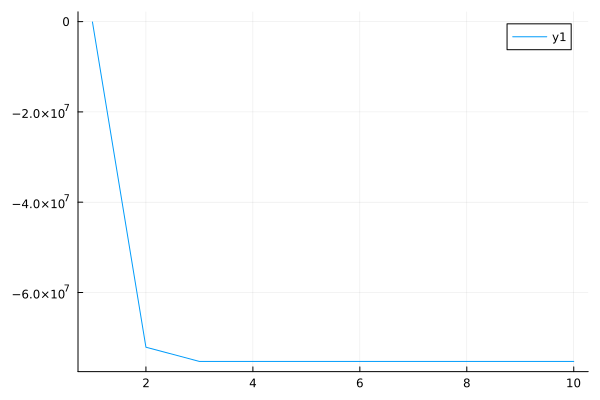

In [7]:
plot(ml)

In [20]:
mls, param_diff, FB, FS = fit!(modeli, y; max_iter=50)

Fitting SLDS via vEM... 100%|██████████████████████████████████████████████████| Time: 0:00:05 ( 0.12  s/it)


([20935.63164864185, -106498.23640606194, -70798.8294672717, -74056.36869027294, -75567.91176193868, -76828.59963589511, -77882.52869767728, -78755.4380813546, -79470.89934117571, -80050.60812535827  …  -80456.62501052546, -80384.59304652021, -80313.00351516421, -80241.86905542645, -80171.19710403822, -80100.99103467514, -80031.25107362753, -79961.9750345755, -79893.15890703376, -79824.7973264398], [1.539859258905009, 4.936699259756284, 1.3607172559053495, 0.19835076339892338, 0.15304199262054247, 0.12606807853165738, 0.10398174553684308, 0.08547573091464537, 0.06987454461202186, 0.056739811376851725  …  0.004858936455894157, 0.0048082743256747645, 0.004757345053007326, 0.0047066588209741895, 0.004656614789977405, 0.004607521564004703, 0.004559614052801742, 0.004513067327654235, 0.004468007983770085, 0.0044245234429327596], StateSpaceDynamics.ForwardBackward{Float64}([-11.084232398985085 -90.38201718823333 … 0.0 0.0; -1.535261526781517e-5 0.0 … -52.229000226379135 -59.02405546305774], 

In [21]:
model.A

2×2 Matrix{Float64}:
 0.96  0.04
 0.04  0.96

In [22]:
modeli.A

2×2 Matrix{Float64}:
 1.0   0.0
 0.25  0.75

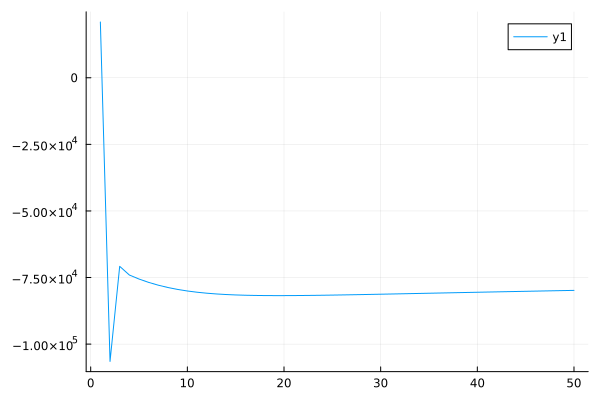

In [23]:
plot(mls)

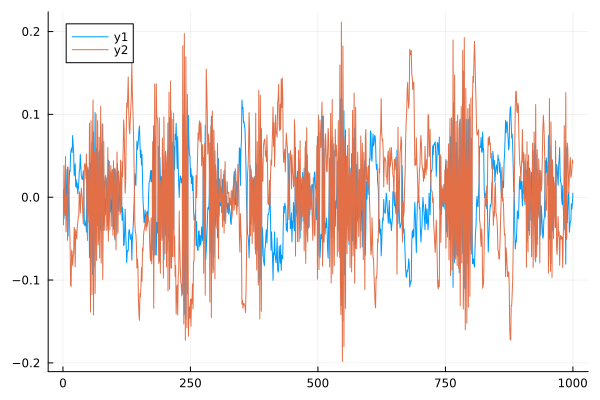

In [11]:
plot(FS[1].x_smooth')

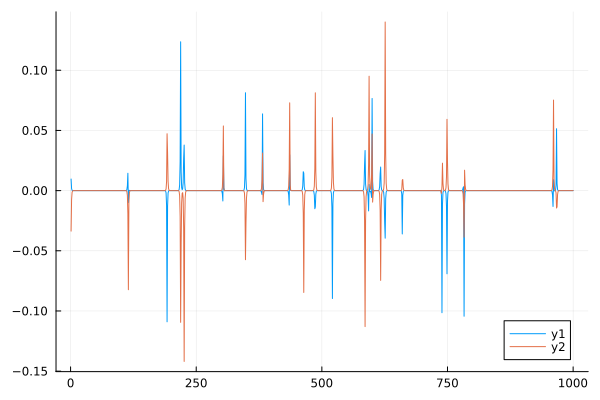

In [12]:
plot(FS[2].x_smooth')

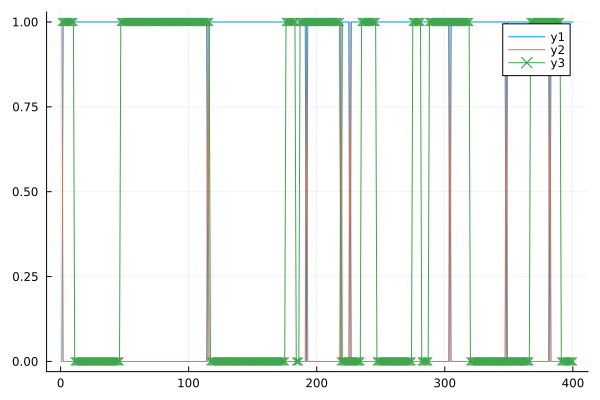

In [13]:
plot(exp.(FB.γ[:,1:400])')
plot!(z[1:400] .- 1, marker=:x)

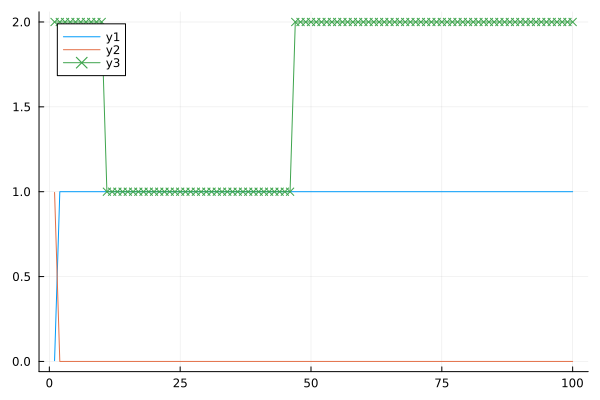

In [14]:
plot(exp.(FB.loglikelihoods[:,1:100])')
plot!(z[1:100], marker=:x)

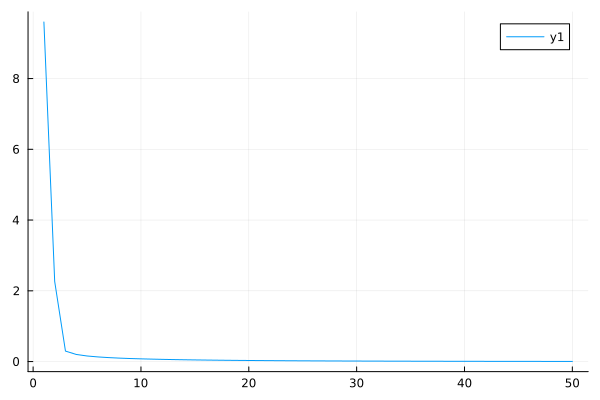

In [15]:
plot(param_diff)